#### Notebook Description

This notebook is used to fit the CTMC-SDE (CTMC) model to a particular day's data. It can be adapted for multiple days with minor adjustments. Due to restrictions placed on the implied volatility data, we are unable to provide more than a single day's data however similar results can be seen for the majority of the other days and currency pairs presented in the paper. The output is a single file 'DATE_ALPHA_ASSET.pickle' where DATE is the current fitted day, ALPHA is the $\alpha$ tuning parameter, and ASSET the currency pair (AUD, EUR, or CAD). The resultant summary file contains various diagnostics of the final fitted results, the details can be seen in the file 'Fit_CTMC.py'.

###### IMPORTANT: 
**The run time of this code is significantly slower than the actual implementation. For simplicity's sake, we have converted code written in C++ into Python which dramatically increases run time. A typical non-parallelized day's fit's runtime is usually in the order of minutes (instead of what is shown here). With additional work, a production version of the code will likely be much faster.**

In [2]:
import numpy as np
import pandas as pd
from Fit_CTMC import FitCTMC
from helpers import get_init_values
from scipy.stats import norm
import pickle
import time
import os
import matplotlib.pyplot as plt

Due to restrictions placed on the data we used, we will only present a single day's implied volatility surface for the currency pair **CAD-USD**. 

In [3]:
# Use a single day's data as example
single_day_data = np.array([[0.0699  , 0.06625 , 0.0635  , 0.06345 , 0.0651  ],
                            [0.0727  , 0.0681  , 0.0642  , 0.0638  , 0.0654  ],
                            [0.07415 , 0.06855 , 0.0635  , 0.06225 , 0.06385 ],
                            [0.0805  , 0.073125, 0.0667  , 0.065075, 0.067   ],
                            [0.084225, 0.076775, 0.0694  , 0.066725, 0.067175],
                            [0.089675, 0.079825, 0.07135 , 0.068175, 0.070125],
                            [0.103675, 0.091075, 0.08105 , 0.078025, 0.079925],
                            [0.11605 , 0.102275, 0.091   , 0.088025, 0.09005 ]])
tau = np.array([0.08333333, 0.16666667, 0.25, 0.5, 0.75,1., 3., 5.])

Here we define a seriers of hyperparameters used to fit the CTMC model to the above day's data. Descriptions of what each parameter represents is commented to the right of the definition.

In [4]:
IDs = ["CAD"]
r_f = 0  # foreign exchange rate
NY = 3  # number of possible states for mixture model at each maturity
delta_list = np.array([10, 25, 50, 75, 90]) / 100  # array of deltas used in raw data
was_p = 0.3  # wassertein distance penalty
num_rand_starts = 20   # Number of random starts initially to compute best starting location
cur_date = '2017-05-26'   # Current data's date, usually unused
output_path = 'Data/'     # Path of output results
a = np.array([0.3])       # Wasserstein penalty hyperparamter 
tte_list = ["1M", "2M", "3M", "6M", "9M", "1Y", "3Y", "5Y"]  # Names of maturities
x0_init = np.array([-0.1, 0, 0.1, 0.02, 0.1, 0.02, 0.2, 0.4, 0.2])  # Initial starting point used in optimizer
num_points = 20           # Number of points to evaluate density at
fail_attempts = 15        # Number of re-optimizations done before taking best result if none are within tolerence bounds

We then run the fit across all maturities consecutively and save the output file as a pickle, including various diagnostics (details can be found at the bottom of the Fit_CTMC_drift file).

In [5]:
start_time = time.time()
ID = IDs[0]
alpha = a[0]

def run_single_fit():
    ctmc_model = FitCTMC()
    cur_ts = pd.Timestamp(cur_date[:10])
    print('Fitting started ...')
    results_day = []
    IV_all = single_day_data
    init = True
    for k in range(len(tau)):
        KFs = np.zeros((5, 1))

        # Calcs the KFs from data
        for m in range(5):
            KFs[m] = np.exp(
                IV_all[k, m] ** 2 * tau[k] / 2 - norm.ppf(np.exp(r_f * tau[k]) * delta_list[m]) * IV_all[
                    k, m] * np.sqrt(tau[k]))
        KFs = np.squeeze(KFs)
        
        loaded_x0 = None # Load in starting values if warm start
                
        if init:
            if loaded_x0 is None:
                loaded_x0 = x0_init

            results = ctmc_model.FitCTMC(
                KFs=KFs,
                tau=tau[:k + 1],
                IV=IV_all[k],
                A_list=[],
                pi0=None,
                mu0=None,
                sigma0=None,
                m0=None,
                pre_mean_Y=None,
                NY=NY,
                was_p=alpha,
                x0=loaded_x0,
                num_points=num_points,
                tol=1e-9,
                init_rs = num_rand_starts,
                fail_attempts=fail_attempts
            )

            init = False
        else:            
            if loaded_x0 is None:
                # Uses last day's current maturity parameters if we are on the second or later date
                loaded_x0 = get_init_values(results_day[-1]["mu"][k - 1], results_day[-1]["sigma"][k - 1],
                                     results_day[-1]["A"][k - 1])

            results = ctmc_model.FitCTMC(
                KFs=KFs,
                tau=tau[:k + 1],
                IV=IV_all[k],
                pi0=pi,
                mu0=mu,
                sigma0=sigma,
                A_list=A_list,
                m0=m0,
                pre_mean_Y=pre_mean_Y,
                NY=NY,
                was_p=alpha,
                x0=loaded_x0,
                num_points=num_points,
                init_rs = num_rand_starts,
                fail_attempts=fail_attempts
            )

        pi = results['pi']
        mu = results['mu']
        sigma = results['sigma']
        A_list = results['A']
        m0 = results['m']
        pre_mean_Y = results['EYs']

        results_day.append(results)
        print("Tau = " + str(tau[k]) + " Complete ..."+ "\n")
        print("--- %s seconds ---" % (time.time() - start_time))

    with open(output_path + cur_date + '_alpha_' + str(alpha) + '_' + ID + '.pickle', 'wb') as handle:
        pickle.dump(results_day, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
run_single_fit()

Fitting started ...
Tau = 0.08333333 Complete ...

--- 2854.128844022751 seconds ---
Result not within error bounds, randomizing
Tau = 0.16666667 Complete ...

--- 5440.910067081451 seconds ---
Tau = 0.25 Complete ...

--- 8739.034434556961 seconds ---
Tau = 0.5 Complete ...

--- 14548.652661323547 seconds ---


/home/brian/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Tau = 0.75 Complete ...

--- 18260.329226970673 seconds ---
Tau = 1.0 Complete ...

--- 22007.796073675156 seconds ---
Tau = 3.0 Complete ...

--- 31853.51564002037 seconds ---
Tau = 5.0 Complete ...

--- 46287.66159033775 seconds ---


Finally, we graph the fitted model together with the data points including both the spline implied density and the corresponding model density. 

In [7]:
# Reload results to plot fits
with open(output_path + cur_date + '_alpha_' + str(a[0]) + '_' + ID + '.pickle', 'rb') as handle:
    fit_info = pickle.load(handle)

Text(0.5, 1.15, 'CTMC Model Fit for CAD-USD on 2017-05-26')

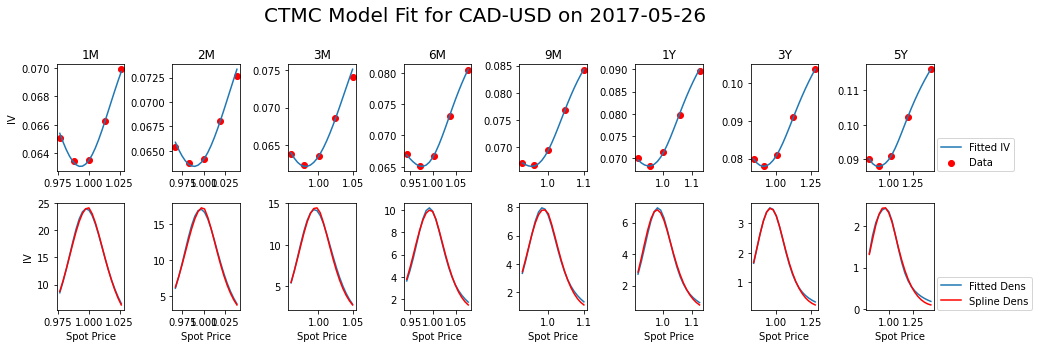

In [8]:
fig, axes = plt.subplots(2, 8, figsize = (13,4))
fig.tight_layout()

for i in range(len(fit_info)):
    axes[0,i].plot(fit_info[i]['KFs'], fit_info[i]['IV_model'], label = 'Fitted IV')
    axes[0,i].scatter(fit_info[i]['sorted_KFs'], fit_info[i]['sorted_IV'], color='r', label = 'Data')
    axes[0,i].set_title(tte_list[i])
    
    axes[1,i].plot(fit_info[i]['KFs'], fit_info[i]['model_density'], label = 'Fitted Dens')
    axes[1,i].plot(fit_info[i]['KFs'], fit_info[i]['data_density'], color = 'r', label = 'Spline Dens')
    axes[1,i].set_xlabel('Spot Price')
    
axes[0, 0].set_ylabel('IV')
axes[1, 0].set_ylabel('IV')
axes[0,-1].legend(prop={'size': 10}, loc=(1.04, 0))
axes[0,-1].set_title(tte_list[i])
axes[1,-1].legend(prop={'size': 10}, loc=(1.04, 0))

fig.suptitle('CTMC Model Fit for ' + IDs[0] + '-USD on ' + cur_date, fontsize = 20, y=1.15)